# Analyse du discours des Banques Centrales

In [1]:
import datetime
import copy as c
import random
import collections
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#!pip install spacy
import spacy
#!pip install langdetect
import langdetect
import nltk
from nltk.corpus import stopwords

In [2]:
url="https://www.ecb.europa.eu/press/key/shared/data/all_ECB_speeches.csv?848ea64ce6d77827b5e8e18790878b64"
#df=pd.read_csv(url,sep = "|",encoding='utf-8')

# Une connexion lente peut obliger à télécharger le fichier en local
url_local=r"C:\Users\Antoine\Downloads\all_ECB_speeches.csv"
df=pd.read_csv(url_local,sep = "|",encoding='utf-8')

# fichier mis à jour tous les mois, dernière version : 1er décembre 2021 (47,8 Mo)
# à récupérer à l'adresse : https://www.ecb.europa.eu/press/key/html/downloads.en.html
# 2549 discours de responsables de la BCE entre 1997 et 2021

In [3]:
df

,date,speakers,title,subtitle,contents
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...
1,2021-11-29,Isabel Schnabel,Inflation im Euroraum: Ursachen und Ausblick,"Presentation by Isabel Schnabel, Member of the...",NaN
2,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...
3,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...
4,2021-11-25,Isabel Schnabel,Inflation im Euroraum: Ursachen und Ausblick,"Presentation by Isabel Schnabel, Member of the...",NaN
...,...,...,...,...,...
2544,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2545,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2546,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2547,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


In [4]:
print(df.isna().sum())
# on affiche un dataframe avec toutes les lignes contenant au moins un NaN
#df[df.isna().any(axis=1)] 

date         0
speakers     1
title        0
subtitle     1
contents    39
dtype: int64


On remarque que pour tous les discours, on a seulement le titre et le speaker mais le contenu est NaN. Il faut donc mettre de côté tous ces discours sans contenu. Ce cas se présente seulement pour 39 discours (soit 1,5% de la base de données).

In [5]:
df=df.dropna(axis='index',how='any')
df=df.reset_index(drop=True)

In [6]:
df.head()

,date,speakers,title,subtitle,contents
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...
1,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...
2,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...
3,2021-11-24,Fabio Panetta,Patient monetary policy amid a rocky recovery,"Speech by Fabio Panetta, Member of the Executi...",SPEECH Patient monetary policy amid a rock...
4,2021-11-22,Luis de Guindos,Ralph Koijen’s contribution to research on the...,"Remarks by Luis de Guindos, Vice-President of ...",SPEECH Ralph Koijen’s contribution to rese...


#### En explorant le dataset, on se rend compte que certains contenus de discours sont vides (empty string mais pas NaN).
#### Il faut donc retirer ces lignes du dataframe.

In [7]:
L=[]
for i in range(len(df)):
    if not bool(df["contents"][i].strip()): #si le contenu du discours est vide
        L.append(i)
L # ne concerne qu'une ligne

[2009]

In [8]:
df=df.drop(L).reset_index(drop=True)
df

,date,speakers,title,subtitle,contents
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...
1,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...
2,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...
3,2021-11-24,Fabio Panetta,Patient monetary policy amid a rocky recovery,"Speech by Fabio Panetta, Member of the Executi...",SPEECH Patient monetary policy amid a rock...
4,2021-11-22,Luis de Guindos,Ralph Koijen’s contribution to research on the...,"Remarks by Luis de Guindos, Vice-President of ...",SPEECH Ralph Koijen’s contribution to rese...
...,...,...,...,...,...
2504,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2505,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2506,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2507,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


#### On se rend compte que certains discours ne sont pas en anglais.
#### Il faut donc les retirer.

On teste différentes méthodes de détection de langue. Ces tests se trouvent dans le notebook *Tests-LanguageDetection.ipynb*.

On utilise ici la méthode qu'on juste la plus adaptée à notre projet alliant rapidité et une efficacité convenable : on analyse les 2000 premiers caractères des discours avec la fonction *detect* de la librairie langdetect.

In [9]:
# Extrait de la documentation https://pypi.org/project/langdetect/#description
# langdetect Language detection algorithm is non-deterministic,
# which means that if you try to run it on a text which is either too short or too ambiguous,
# you might get different results everytime you run it.
# To enforce consistent results, call following code before the first language detection:

langdetect.DetectorFactory.seed = 0

In [10]:
start = time.time()
EN=0 #nombre de discours en anglais
OTHERS=0 #nombre de discours dans d'autres langues
M=[] #liste de chaines de caractères avec les langues détectées (autres que l'anglais)
I=[] #liste de numéros de lignes des discours qui ne sont pas en anglais
s=''
n=len(df) #longueur du dataframe 

for i in range(n):
    s=langdetect.detect(df["contents"][i][:2000])
    if s=='en': #si la langue détectée est l'anglais
        EN+=1
    else: #si l'on détecte une autre langue majoritaire
        OTHERS+=1
        M.append(s)
        I.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.9294539657233958
Temps pris par cette méthode : 19.53878378868103
"""

Proportion de discours en anglais :  0.9286568353925867
Temps pris par cette méthode : 31.003387212753296


'\nProportion de discours en anglais :  0.9294539657233958\nTemps pris par cette méthode : 19.53878378868103\n'

### Modification du dataframe

In [11]:
#df["Language"]=pd.Series(dtype=str)
#On pourrait ajouter une colonne "language" pour une analyse ultérieure
#si on veut conserver les discours dans toutes les langues

In [12]:
# On retire les discours qui ne sont pas en anglais des données à analyser
df=df.drop(I).reset_index(drop=True)
df

,date,speakers,title,subtitle,contents
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...
1,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...
2,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...
3,2021-11-24,Fabio Panetta,Patient monetary policy amid a rocky recovery,"Speech by Fabio Panetta, Member of the Executi...",SPEECH Patient monetary policy amid a rock...
4,2021-11-22,Luis de Guindos,Ralph Koijen’s contribution to research on the...,"Remarks by Luis de Guindos, Vice-President of ...",SPEECH Ralph Koijen’s contribution to rese...
...,...,...,...,...,...
2325,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2326,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2327,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2328,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


En nettoyant le jeu de données, on conserve plus de 90% des discours (pour les données mises à jour le 1er décembre 2021, 2330 discours sur 2549), ce qui est tout à fait satisfaisant.

In [13]:
df.sample(5)
#a priori ces discours sont bien en anglais

,date,speakers,title,subtitle,contents
683,2015-09-24,Peter Praet,Monetary policy lessons from the financial cri...,"Dinner speech by Peter Praet, Member of the Ex...",Monetary policy lessons from the financial c...
2160,2000-05-12,Willem F. Duisenberg,Official celebration of the 150th anniversary ...,"Speech delivered by Dr. Willem F. Duisenberg, ...",Official celebration of the 150th anniversar...
323,2018-07-01,Yves Mersch,Are the economy and monetary policy at a turni...,"Speech by Yves Mersch, Member of the Executive...",Are the economy and monetary policy at a tur...
1141,2011-05-18,Vítor Constâncio,Strengthening European economic governance - s...,"Speech by Vítor Constâncio, Vice-President of ...",Strengthening European economic governance –...
360,2018-03-09,Sabine Lautenschläger,Cyber resilience – objectives and tools,"Speech by Sabine Lautenschläger, Member of the...",Cyber resilience – objectives and tools Sp...


### Ajout de colonnes au dataframe

Pour les premières étapes de statistiques descriptives du dataframe, il parait pertinent de créer d'autres colonnes à partir de la colonne "date" pour faciliter la manipulation des données.

On crée donc trois colonnes pour le jour, le mois et l'année qu'on établit à partir de "date".

In [14]:

df["Year"]=df.date.str[:4].astype(int)
df["Month"]=df.date.str[5:7].astype(int)
df["Day"]=df.date.str[8:].astype(int)


Puis on ajoute le mois et le jour de la semaine (de type str).

In [15]:
week=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
months=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df["DayofWeek"]=pd.Series(dtype=int)
df["DayofWeek_str"]=pd.Series(dtype=str)
df["Month_str"]=pd.Series(dtype=str)
for i in range(len(df)):
    df["DayofWeek"][i]=int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).isoweekday())
    df["DayofWeek_str"][i]=week[int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).weekday())]
    df["Month_str"][i]=months[df["Month"][i]-1]

#.weekday() : from 0 to 6
#.isoweekday() : from 1 to 7

df["DayofWeek"]=df["DayofWeek"].astype(int)

C:\Users\Antoine\AppData\Local\Temp/ipykernel_21156/494173469.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DayofWeek"][i]=int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).isoweekday())
C:\Users\Antoine\AppData\Local\Temp/ipykernel_21156/494173469.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DayofWeek_str"][i]=week[int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).weekday())]
C:\Users\Antoine\AppData\Local\Temp/ipykernel_21156/494173469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

In [16]:
df.sample(5)

,date,speakers,title,subtitle,contents,Year,Month,Day,DayofWeek,DayofWeek_str,Month_str
922,2013-06-03,Benoît Cœuré,Global liquidity and international risk-sharin...,"Speech by Benoît Cœuré, Member of the Executiv...",Global liquidity and international risk-shar...,2013,6,3,1,Monday,June
920,2013-06-11,Jörg Asmussen,Introductory statement by the ECB in the proce...,"Jörg Asmussen, Member of the Executive Board o...",Introductory statement by the ECB in the pro...,2013,6,11,2,Tuesday,June
1478,2008-06-09,Lucas Papademos,Opening remarks at the press briefing on the o...,"Lucas Papademos, Vice-President of the ECB Fra...",Opening remarks at the press briefing on the...,2008,6,9,1,Monday,June
488,2017-04-06,Peter Praet,Calibrating unconventional monetary policy,"Speech by Peter Praet, Member of the Executive...",Calibrating unconventional monetary policy ...,2017,4,6,4,Thursday,April
1479,2008-06-09,Gertrude Tumpel-Gugerell,"Central banks, liquidity and a changing financ...","Speech by Gertrude Tumpel-Gugerell, Member of ...","Central banks, liquidity and a changing fina...",2008,6,9,1,Monday,June


## Première analyse des données 

### Répartition des discours dans le temps

Une première étape de l'analyse du jeu de données qui parait pertinente est l'observation de la répartition des discours dans le temps selon les années, les mois et les jours.

#### Nombre de discours par an

<AxesSubplot:title={'center':'Evolution du nombre annuel de discours du Comité Exécutif de la BCE'}, xlabel='Année'>

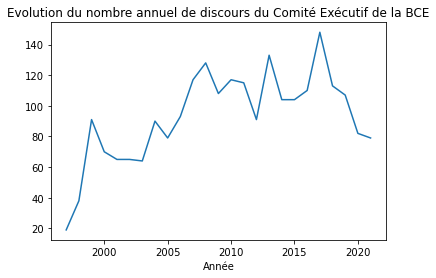

In [17]:
df_year=df.groupby("Year").count()
df_year["date"].plot(title='Evolution du nombre annuel de discours du Comité Exécutif de la BCE', xlabel="Année")

In [63]:
df.groupby("Year").count()

,date,speakers,title,subtitle,contents,Month,Day,DayofWeek,DayofWeek_str,Month_str
Year,,,,,,,,,,
1997,19,19,19,19,19,19,19,19,19,19
1998,38,38,38,38,38,38,38,38,38,38
1999,91,91,91,91,91,91,91,91,91,91
2000,70,70,70,70,70,70,70,70,70,70
2001,65,65,65,65,65,65,65,65,65,65
2002,65,65,65,65,65,65,65,65,65,65
2003,64,64,64,64,64,64,64,64,64,64
2004,90,90,90,90,90,90,90,90,90,90
2005,79,79,79,79,79,79,79,79,79,79


<AxesSubplot:title={'center':'Nombre de discours du Comité Exécutif de la BCE par an'}, xlabel='Année'>

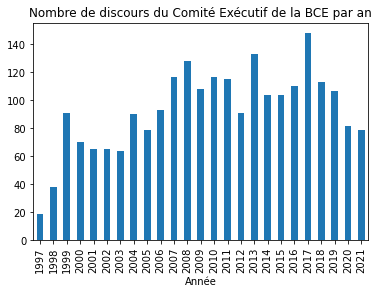

In [18]:
df_year=df.groupby("Year").count()
df_year["date"].plot(kind='bar',title='Nombre de discours du Comité Exécutif de la BCE par an', xlabel="Année")

Depuis la création de la Banque Centrale européenne, on constate une hausse significative du nombre de discours du comité exécutif de la BCE : aucune année ne dépasse 100 discours jusqu'en 2006 alors que depuis le nombre de discours n'a été inférieur à 100 qu'en 2012, 2020 et 2021, avec une situation exceptionnelle (crise sanitaire mondiale) pour ces deux dernières années. On pourrait émettre l'hypothèse que les pics du graphique correspondent aux crises : crise des subprimes en 2008, Brexit en 2017 par exemple.

#### Nombre de discours selon les mois 

<AxesSubplot:title={'center':"Nombre de discours par mois de l'année"}, xlabel='Month'>

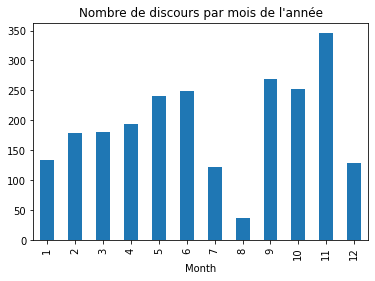

In [19]:
df_month=df.groupby("Month").count()
df_month["date"].plot(kind='bar', title="Nombre de discours par mois de l'année")

<AxesSubplot:title={'center':"Nombre de discours par mois de l'année"}, xlabel='Month'>

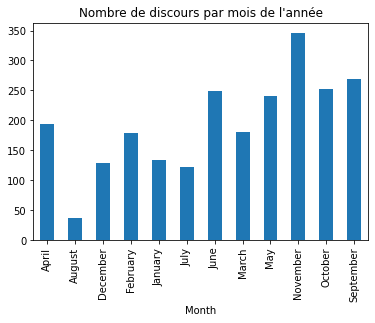

In [20]:
df_month=df.groupby("Month_str").count()
df_month["date"].plot(kind='bar', title="Nombre de discours par mois de l'année", xlabel='Month')

Text(0.5, 1.0, 'On which month are ECB speeches delivered?')

<Figure size 432x288 with 0 Axes>

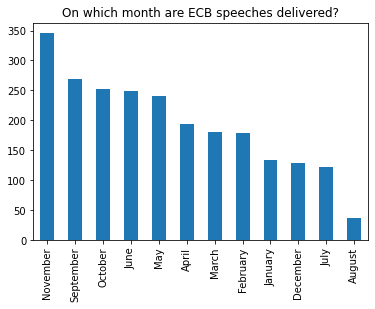

In [21]:
plt.clf()
plt.figure()

df["Month_str"].value_counts().plot(kind="bar")
plt.title("On which month are ECB speeches delivered?")

In [22]:
#Les mois ne sont pas ordonnés dans l'ordre chronologique mais ordre décroissant du nombre de discours.

On constate une forte saisonnalité des discours à la BCE : la plupart des discours sont prononcés pendant les trois mois de la "rentrée" (septembre, octobre, novembre) avec un maximum en novembre mais aussi dans une moindre mesure pendant les trois mois avant l'été (avril, mai, juin). Le nombre de discours chute pendant la période des vacances d'été (juillet et août), particulièrement en août.

#### Nombre de discours selon les jours du mois

<AxesSubplot:title={'center':'Nombre de discours de la BCE selon les jours du mois'}, xlabel='Jour'>

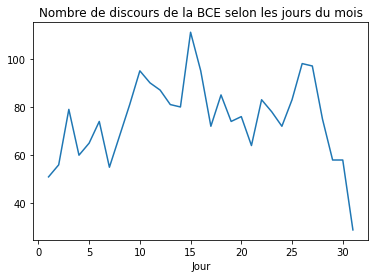

In [23]:
df_day=df.groupby("Day").count()
df_day["date"].plot(title="Nombre de discours de la BCE selon les jours du mois", xlabel='Jour')

<AxesSubplot:title={'center':'Nombre de discours de la BCE selon les jours du mois'}, xlabel='Jour'>

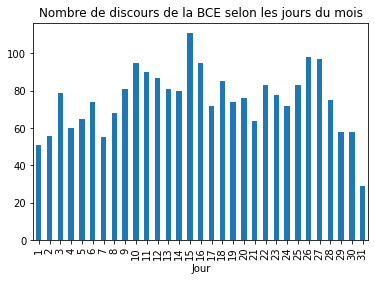

In [24]:
df_day=df.groupby("Day").count()
df_day["date"].plot(kind='bar', title="Nombre de discours de la BCE selon les jours du mois", xlabel='Jour')

#### Nombre de discours selon les jours de la semaine

<AxesSubplot:title={'center':'Nombre de discours de la BCE selon le jour de la semaine'}, xlabel='Jour de la semaine'>

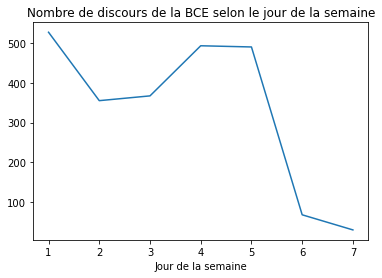

In [25]:
df_day=df.groupby("DayofWeek").count()
df_day["date"].plot(title="Nombre de discours de la BCE selon le jour de la semaine", xlabel="Jour de la semaine")

<AxesSubplot:title={'center':'Nombre de discours de la BCE selon le jour de la semaine'}, xlabel='Jour de la semaine'>

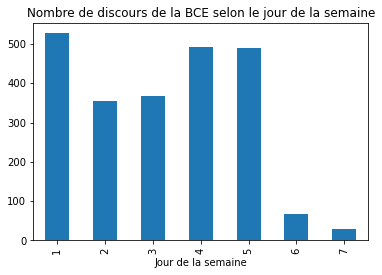

In [26]:
df_day=df.groupby("DayofWeek").count()
df_day["date"].plot(kind="bar",title="Nombre de discours de la BCE selon le jour de la semaine", xlabel="Jour de la semaine")

On remarque que les discours de la BCE de notre échantillon ne sont pas répartis identiquement selon les jours de la semaine : ils sont majoritairement prononcés le premier jour de la semaine (lundi) et les deux jours avant le week-end (jeudi et vendredi), avec une chute conséquente le samedi et le dimanche, qui sont aussi les jours de fermeture des marchés boursiers dans le monde.

In [27]:
n_dates=df["date"].nunique()
print("Il y a",
      n_dates,
      "dates distinctes dans ce jeu de données, soit en moyenne environ",
      round(n_dates/len(df),3),
      "discours par jour.")

Il y a 1805 dates distinctes dans ce jeu de données, soit en moyenne environ 0.775 discours par jour.


<AxesSubplot:>

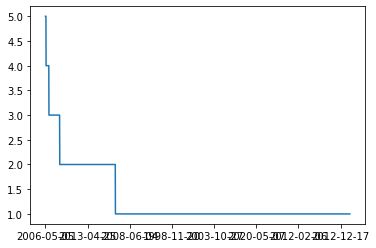

In [28]:

df["date"].value_counts().plot()
# Graphique très laid mais qui permet de voir qu'il y a un nombre de jours non négligeable pour lesquels il y a eu plusieurs discours


In [29]:
#Pour aller plus loin dans l'analyse du nombre de discours par jour
print("Il y a",
      (df["date"].value_counts()>=2).sum(),
      "jours pour lesquels plus qu'un seul discours, soit",
      round(((df["date"].value_counts()>=2).sum()/n_dates)*100,2),
      "% de l'échantillon étudié.")

print("Il y a",
      (df["date"].value_counts()==2).sum(),
      "jours pour lesquels on a 2 discours.")
print("Il y a",
      (df["date"].value_counts()==3).sum(),
      "jours pour lesquels on a 3 discours.")
print("Il y a",
      (df["date"].value_counts()==4).sum(),
      "jours pour lesquels on a 4 discours.")
print("Il y a",
      (df["date"].value_counts()==5).sum(),
      "jours pour lesquels on a 5 discours.")

Il y a 415 jours pour lesquels plus qu'un seul discours, soit 22.99 % de l'échantillon étudié.
Il y a 330 jours pour lesquels on a 2 discours.
Il y a 64 jours pour lesquels on a 3 discours.
Il y a 17 jours pour lesquels on a 4 discours.
Il y a 4 jours pour lesquels on a 5 discours.


In [30]:
array=df["DayofWeek"].value_counts().to_numpy()
array

array([527, 493, 490, 367, 355,  68,  30], dtype=int64)

Text(0.5, 1.0, 'Top 15 ECB Speakers')

<Figure size 432x288 with 0 Axes>

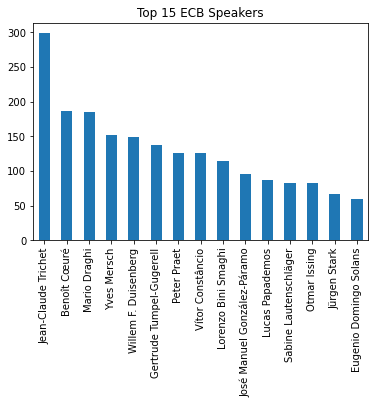

In [31]:
plt.clf()
plt.figure()

df["speakers"].value_counts()[:15].plot(kind="bar")

plt.title("Top 15 ECB Speakers")

## Début de l'analyse pour le NLP

In [32]:
rawtext=''
L=random.sample(range(len(df)),5)
for i in L:
    rawtext+=df["title"][i]+df["contents"][i]
# On commence par analyser 15 discours choisis au hasard 

In [33]:
rawtext[:500]

'Central bank independence  Central bank independence   First Lamfalussy Lecture by Mario Draghi, President of the ECB, at the Banque Nationale de Belgique, Brussels, 26 October 2018 Advanced economies are now emerging from the aftermath of the great financial crisis. Despite facing the largest shock in the postwar period, central banks have succeeded in maintaining price stability and fulfilling their mandates.  A key factor behind this has been central bank independence. But in spite of its ben'

In [34]:
# Reconnaissance des entités nommées

nlp = spacy.load("en_core_web_lg")
doc = nlp(rawtext)
spacy.displacy.render(doc, style="ent", jupyter=True)

In [35]:
#Il faut définir un liste de stopwords (c'est-à-dire de mots non significatifs) 
#En anglais 
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [36]:

alphabet=set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ') #type(alphabet)=set "ensemble"
stop_words= stop_words | alphabet # On fait une union d'ensembles pour retirer des nuages de mots les lettres isolées
#L'étape précédeente peut êtr évitée en spécifiant min_word_length=2 dans la fonction WordCloud
wordlist=['The','It','And','this','This','The','the','these','These','those','Those','In','&','one','He','She','he','she','it','\\displaystyle','\\mathbb','\\neg','per','th','also','would','de','la']
stop_words.update(wordlist) #on ajoute des mots aux 'stopwords'

In [37]:
#Fonction qui permet d'obtenir une liste de mots en minuscules sans les stopwords

def str_to_wordlist(text):
    text2 = c.copy(text)
    text2 = text2.lower() # minuscules
    text2 = re.sub(r'\d+','',text2) # enlever les nombres
    text2 = re.findall(r'\w+', text2) # enlever la ponctuation
    text2 = [word for word in text2 if not word in stop_words and len(word)>2] # enlever les stopwords
    return(text2)

#text = str_to_wordlist(text)

In [38]:
def freq_dict(text):
    res = {}
    for word in text:
        try:
            res[word] += 1
        except KeyError:
            res[word] = 1
    return(res)


#dictionary = freq_dict(rawtext)

In [39]:
"Fonction pour récupérer les fréquences des mots d'un texte"

def freq_mots(text,stopwords):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+','',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    T=[mot for mot in text.split() if mot not in list(stopwords)]
    return collections.Counter(T)


In [40]:
freq_mots(rawtext,stop_words)

Counter({'Central': 14,
         'bank': 29,
         'independence': 29,
         'First': 9,
         'Lamfalussy': 1,
         'Lecture': 1,
         'Mario': 1,
         'Draghi': 1,
         'President': 6,
         'ECB': 33,
         'Banque': 1,
         'Nationale': 1,
         'Belgique': 1,
         'Brussels': 2,
         'October': 2,
         'Advanced': 1,
         'economies': 33,
         'emerging': 14,
         'aftermath': 3,
         'great': 7,
         'financial': 90,
         'crisis': 55,
         'Despite': 2,
         'facing': 2,
         'largest': 3,
         'shock': 2,
         'postwar': 1,
         'period': 10,
         'central': 61,
         'banks': 47,
         'succeeded': 1,
         'maintaining': 2,
         'price': 35,
         'stability': 50,
         'fulfilling': 4,
         'mandates': 8,
         'key': 10,
         'factor': 8,
         'behind': 2,
         'But': 20,
         'spite': 1,
         'benefits': 10,
         'desirabil

In [41]:
"Fonction pour récupérer la liste des mots d'un texte brut"
def liste_mots(text,stopwords):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    return [mot for mot in text.split() if mot not in list(stopwords)]

In [42]:
liste_mots(rawtext,stop_words)

['Central',
 'bank',
 'independence',
 'Central',
 'bank',
 'independence',
 'First',
 'Lamfalussy',
 'Lecture',
 'Mario',
 'Draghi',
 'President',
 'ECB',
 'Banque',
 'Nationale',
 'Belgique',
 'Brussels',
 'October',
 'Advanced',
 'economies',
 'emerging',
 'aftermath',
 'great',
 'financial',
 'crisis',
 'Despite',
 'facing',
 'largest',
 'shock',
 'postwar',
 'period',
 'central',
 'banks',
 'succeeded',
 'maintaining',
 'price',
 'stability',
 'fulfilling',
 'mandates',
 'key',
 'factor',
 'behind',
 'central',
 'bank',
 'independence',
 'But',
 'spite',
 'benefits',
 'desirability',
 'relevance',
 'nowadays',
 'increasingly',
 'challenged',
 'evolution',
 'central',
 'bank',
 'independence',
 'rationale',
 'delegating',
 'powers',
 'independent',
 'central',
 'banks',
 'evolved',
 'mainly',
 'experience',
 'At',
 'time',
 'policymakers',
 'believed',
 'stable',
 'trade',
 'unemployment',
 'inflation',
 'whereby',
 'monetary',
 'policy',
 'could',
 'achieve',
 'permanently',
 'hig

In [43]:
"Fonction pour récupérer les n mots les plus fréquents (hors stopwords) dans un texte brut"
def plus_frequents(text,n,stopwords):
    L=[]
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    T=[mot for mot in text.split() if mot not in list(stopwords)]
    for tuple in collections.Counter(T).most_common(n):
        L.append([tuple[0],tuple[1]])
    return L

In [44]:
n=20
plus_frequents(rawtext,n,stop_words)

[['euro', 102],
 ['area', 96],
 ['policy', 92],
 ['financial', 90],
 ['monetary', 88],
 ['economic', 83],
 ['countries', 76],
 ['global', 68],
 ['inflation', 62],
 ['central', 61],
 ['fiscal', 58],
 ['crisis', 55],
 ['stability', 50],
 ['banks', 47],
 ['policies', 47],
 ['union', 46],
 ['international', 39],
 ['system', 39],
 ['price', 35],
 ['national', 35]]

In [45]:
rawtext=''
L=random.sample(range(len(df)),50)
for i in L:
    rawtext+=df["title"][i]+df["contents"][i]
# On commence par analyser 15 discours choisis au hasard 

In [46]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

#tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

#example_sent = "This is a sample sentence,showing off the stop words filtration."

def tokens_filter(text,stop_words):
    word_tokens = tokenizer.tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] #retire les stopwords
    return filtered_sentence

text=tokens_filter(rawtext,stop_words)

In [47]:
collections.Counter(text).most_common(20)

[('euro', 1219),
 ('policy', 1062),
 ('monetary', 995),
 ('area', 906),
 ('financial', 770),
 ('ECB', 670),
 ('stability', 528),
 ('growth', 524),
 ('economic', 518),
 ('market', 482),
 ('inflation', 460),
 ('European', 451),
 ('price', 451),
 ('countries', 422),
 ('rate', 411),
 ('rates', 406),
 ('interest', 374),
 ('term', 341),
 ('central', 330),
 ('banks', 326)]

## les n-grams

In [48]:
nltk.download('genesis')
nltk.corpus.genesis.words('english-web.txt')

[nltk_data] Error loading genesis: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


['In', 'the', 'beginning', 'God', 'created', 'the', ...]

In [49]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

## Bigrams
finder = BigramCollocationFinder.from_words(
   text)
# only bigrams that appear 3+ times
finder.apply_freq_filter(3)


# return the 10 n-grams with the highest PMI
# print (finder.nbest(bigram_measures.likelihood_ratio, 10))

for i in finder.score_ngrams(bigram_measures.likelihood_ratio):
    print (i)

(('euro', 'area'), 7367.372266025205)
(('monetary', 'policy'), 4838.868809797612)
(('price', 'stability'), 2516.1645522575277)
(('interest', 'rates'), 1922.9648085426754)
(('central', 'bank'), 1776.5780637059424)
(('Governing', 'Council'), 1563.9410274806346)
(('Member', 'States'), 1399.5230205418648)
(('medium', 'term'), 1101.2855957432769)
(('Central', 'Bank'), 1026.048608336651)
(('interest', 'rate'), 926.3146441329158)
(('long', 'term'), 821.3970521291881)
(('United', 'States'), 811.004416801897)
(('central', 'banks'), 805.9084341925773)
(('exchange', 'rate'), 760.4690244736461)
(('Mr', 'Duisenberg'), 656.6474039207819)
(('short', 'term'), 650.7632354662012)
(('structural', 'reforms'), 642.51280903416)
(('Working', 'Paper'), 641.0811773237987)
(('macro', 'prudential'), 600.3613021980937)
(('Executive', 'Board'), 569.9443138541995)
(('European', 'Central'), 545.9967451136076)
(('Federal', 'Reserve'), 521.6384521510853)
(('cross', 'border'), 509.5377116357496)
(('financial', 'system'

In [50]:
## Trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()


finder = TrigramCollocationFinder.from_words(
   text)
# only trigrams that appear 3+ times
finder.apply_freq_filter(3)


# return the 10 n-grams with the highest PMI
# print (finder.nbest(trigram_measures.likelihood_ratio, 10))
for i in finder.score_ngrams(trigram_measures.likelihood_ratio):
    print (i)

(('euro', 'area', 'countries'), 7809.480511401678)
(('across', 'euro', 'area'), 7572.090038214926)
(('euro', 'area', 'whole'), 7524.314219435215)
(('outside', 'euro', 'area'), 7449.171927390298)
(('within', 'euro', 'area'), 7438.11083266678)
(('stability', 'euro', 'area'), 7434.0571974980885)
(('join', 'euro', 'area'), 7426.230207239822)
(('euro', 'area', 'economy'), 7422.33768733469)
(('euro', 'area', 'average'), 7421.989115505015)
(('enlarged', 'euro', 'area'), 7413.287605532981)
(('representation', 'euro', 'area'), 7406.48401654558)
(('parts', 'euro', 'area'), 7404.356671671319)
(('differentials', 'euro', 'area'), 7402.312298708548)
(('euro', 'area', 'wide'), 7400.97013149578)
(('recovery', 'euro', 'area'), 7394.96009885206)
(('performance', 'euro', 'area'), 7394.512114174387)
(('segments', 'euro', 'area'), 7394.449841201327)
(('rates', 'euro', 'area'), 7392.223259309604)
(('part', 'euro', 'area'), 7391.185842989729)
(('vis', 'euro', 'area'), 7391.021681387109)
(('number', 'euro', '

In [51]:
#Lemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()
 
print("rocks :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))
 
# a denotes adjective in "pos"
print("better :", lemmatizer.lemmatize("better", pos ="a"))


[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


rocks : rock
corpora : corpus
better : good


In [52]:
lemmatizer.lemmatize("thieves")

'thief'

In [53]:
#Most frequent words by year
years=df["Year"].unique()

def year_speeches(df,year):
    #df : pandas dataframe
    #year : int
    text=''
    df_year=df[df["Year"] == year].reset_index(drop=True)
    for i in range(len(df_year)):
        text+=df_year["title"][i]+df_year["contents"][i]
    return text



In [54]:
year=2010
year_speeches(df,year)

'Introductory remarks at the International Club of Economic Journalists  Introductory remarks at the International Club of Economic Journalists   Jean-Claude Trichet, President of the European Central Bank, Frankfurt am Main, 13 December 2010 Ladies and Gentlemen, It is a true pleasure for me to participate in the meeting co-organised with the International Club of Frankfurt Economic Journalists. I vividly remember the interesting discussions we had in December 2008. At the time, I took the opportunity to discuss the changes in central banking communication. Today, I would like to focus on the current situation regarding Economic and Monetary Union.  Let me start by quoting from a famous speech that, according to the ancient Greek historian Thucydides, the Athenian statesman and leader Pericles delivered to his fellow citizens during the Peloponnesian War more than 2400 years ago:  “Our constitution does not copy the laws of neighbouring states; we are rather a pattern to others than i

In [55]:
def freq_words_year(df,year,n=10):
    #df : pandas dataframe
    #year : int
    #n : int
    text=year_speeches(df,year)
    return collections.Counter(tokens_filter(text,stop_words)).most_common(n)

In [56]:
year=2008
df_year=df[df["Year"] == year].reset_index(drop=True)
df_year

,date,speakers,title,subtitle,contents,Year,Month,Day,DayofWeek,DayofWeek_str,Month_str
0,2008-12-15,Jean-Claude Trichet,The changing role of communication,"Introductory Remarks by Jean-Claude Trichet, P...",The changing role of communication Introdu...,2008,12,15,1,Monday,December
1,2008-12-15,Lucas Papademos,Opening remarks at the press briefing on the ...,"Speech by Lucas Papademos, Vice President of t...",Opening remarks at the press briefing on the...,2008,12,15,1,Monday,December
2,2008-12-11,Jean-Claude Trichet,European Financial Integration,"Speech by Jean-Claude Trichet, President of th...",European Financial Integration Speech by J...,2008,12,11,4,Thursday,December
3,2008-12-10,Jürgen Stark,"Issues paper for the conference ""The financial...","Speech by Jürgen Stark, Member of the Executiv...","Issues paper for the conference ""The financi...",2008,12,10,3,Wednesday,December
4,2008-12-09,Lorenzo Bini Smaghi,The Financial Crisis and Global Imbalances: Tw...,"Speech by Lorenzo Bini Smaghi, Member of the E...",The Financial Crisis and Global Imbalances: ...,2008,12,9,2,Tuesday,December
...,...,...,...,...,...,...,...,...,...,...,...
123,2008-01-16,Jean-Claude Trichet,A few remarks on communication by central banks,"Keynote address by Jean-Claude Trichet, Presid...",A few remarks on communication by central ba...,2008,1,16,3,Wednesday,January
124,2008-01-16,Jürgen Stark,Knowns and unknowns about the creation of econ...,"Speech by Jürgen Stark, Member of the Executiv...",Knowns and unknowns about the creation of ec...,2008,1,16,3,Wednesday,January
125,2008-01-12,Jean-Claude Trichet,The successful entry of Malta into the euro area,"Speech by Jean-Claude Trichet, President of th...",The successful entry of Malta into the euro ...,2008,1,12,6,Saturday,January
126,2008-01-05,Lucas Papademos,Monetary policy communication and effectiveness,"Speech by Lucas Papademos, Vice President of t...",Monetary policy communication and effectiven...,2008,1,5,6,Saturday,January


In [57]:
df_year["contents"][0][:1000]

'  The changing role of communication   Introductory Remarks by Jean-Claude Trichet, President of the ECBat a dinner with members of the Internationaler Club Frankfurter Wirtschaftsjournalisten Frankfurt am Main,15 December 2008 Ladies and gentlemen,  A very warm welcome to all of you and thank you very much for your invitation to this club evening. I am happy to see many familiar faces in the audience tonight. Communication is a very important issue for all times. Being here in Frankfurt I am thinking of the very profound remark by Goethe: “Niemand würde in Gesellschaften viel sprechen, wenn er sich bewuβt wäre, wie oft er die anderen missversteht“. Nevertheless let me be bold enough to share with you some thoughts on communication and central banks. Communication is a key element for central banks to enhance the effectiveness, predictability and credibility of their monetary policy decisions. It becomes even more important in difficult times, when the economic outlook darkens and con

In [58]:
year=2005
L=freq_words_year(df,year,20)
x=[]
y=[]
z=[]
for i in range(len(L)):
    x.append(L[i][0])
    y.append(L[i][1])
    z.append(round(100*L[i][1]/L[0][1],1))


<BarContainer object of 20 artists>

<Figure size 432x288 with 0 Axes>

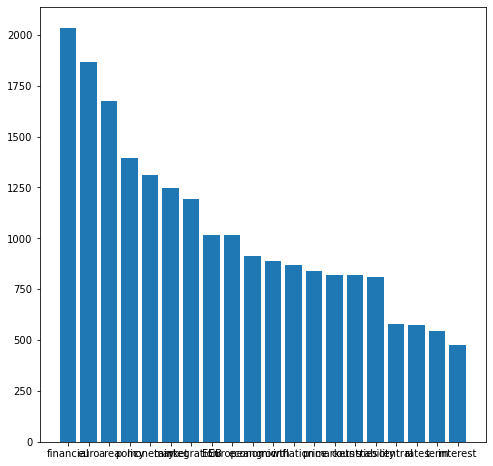

In [59]:
plt.clf()
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(x,y)

In [60]:
freq_words_year(df,2005,20)

[('financial', 2035),
 ('euro', 1865),
 ('area', 1676),
 ('policy', 1395),
 ('monetary', 1310),
 ('market', 1245),
 ('integration', 1191),
 ('ECB', 1016),
 ('European', 1015),
 ('economic', 911),
 ('growth', 887),
 ('inflation', 869),
 ('price', 840),
 ('markets', 819),
 ('countries', 819),
 ('stability', 811),
 ('central', 578),
 ('rates', 575),
 ('term', 543),
 ('interest', 477)]

In [61]:
# https://spacytextblob.netlify.app/docs/